# Aggregate multiple datasets to one

Thsi section defines some stuff for running the script. 

In [65]:
import os
import glob
import zipfile
import itertools
import pandas as pd

# -----------------------------
# Global variables
# -----------------------------
# List of models (as provided)
MODELS_FULL = [
    "meta-llama/Llama-3.1-8B-Instruct",
    "kaist-ai/janus-7b",
    "mistralai/Mixtral-8x7B-Instruct-v0.1",
    # "meta-llama/Llama-3.3-70B-Instruct",
    "mistralai/Mistral-7B-Instruct-v0.3",
]
# Process model names
MODELS = [model.split("/")[-1] for model in MODELS_FULL]

# Prompt methods to process
PROMPT_METHODS = ["cot", "direct", "icl"]

# The input dataset directories (each should contain a CSV per model)
DATASETS_FULL = [
    "tau/commonsense_qa",
    "cais/mmlu",
    "truthfulqa/truthful_qa",
]
# Process dataset names
DATASETS = [dataset.split("/")[-1] for dataset in DATASETS_FULL]

DATASET_LENS = {
    "commonsense_qa": 1221,
    "mmlu": 5170,
    "truthful_qa": 817,
}

# The target output subdirectory (under each prompt method) where aggregated results are saved.
TARGET_DATASET = "full"
# The robust dataset to use for aggregation
ROBUST_PATH = os.path.join("data", "robuset.csv")

from preferences.prefs import MMLU_PREFS, TQA_PREFS, CQA_PREFS

DATASET_PREFERENCES = {
  "tau/commonsense_qa": CQA_PREFS,
  "cais/mmlu": MMLU_PREFS,
  "truthfulqa/truthful_qa": TQA_PREFS,
  "commonsense_qa": CQA_PREFS,
  "mmlu": MMLU_PREFS,
  "truthful_qa": TQA_PREFS,
}

## Check if for all models/method, all files exist

This part checks if all datasets (configured above) exists one and only one csv files for a particular (prompt method, model) pair, and whether it has the same length. Stats are printed for missing files for each combination, so you know which runs are still missing. 

In [66]:
valid_combinations = []

# First, verify the robust dataset exists.
if not os.path.exists(ROBUST_PATH):
    print(f"Robust dataset not found at {ROBUST_PATH}. Exiting.")
    exit(0)
robust_df = pd.read_csv(ROBUST_PATH)
robust_rows = len(robust_df)

def detect_and_add(method, dataset, model, combo_files):
    file_pattern1 = os.path.join("results", "mcq_results", "relevant", method, dataset, model+"*.csv")
    file_pattern2 = os.path.join("results", "mcq_results", "relevant", method, dataset, model+".csv")
    # print(f"Checking {file_pattern1} and {file_pattern2}")
    files = list(set(glob.glob(file_pattern1) + glob.glob(file_pattern2)))
    if files:
        if len(files) > 1:
            print(f"Warning: Multiple files found for [{method}, {model}, {dataset}]. Check combination")
            return False
        combo_files.append(files[0])
        return True
    return False

# Check all files exist
for method, model in itertools.product(PROMPT_METHODS, MODELS):
    # print(f"\nChecking {method}, {model}")
    print("")
    combo_files = []
    for dataset in DATASETS:
        if detect_and_add(method, dataset, model, combo_files):
            continue
        # Otherwise, try the zipped version
        zip_file = os.path.join("results", "mcq_results", "relevant", method, dataset, model+".zip")
        if os.path.exists(zip_file):
            with zipfile.ZipFile(zip_file, "r") as zip_ref:
                zip_ref.extractall(os.path.join("results", "mcq_results", "relevant", method, dataset))
            if detect_and_add(method, dataset, model, combo_files):
                continue
        print(f"Warning: No files found for [{method}, {model}, {dataset}]")
        continue
    if len(combo_files) != len(DATASETS):
        print(f"Incomplete files for [{method}, {model}]")
        continue
    # Add to valid combinations
    valid_combinations.append((method, model, combo_files))
    print(f"Completed files for {method}, {model}")

print(f"Found {len(valid_combinations)}/{len(PROMPT_METHODS)*len(MODELS)} valid combinations:")
for method, model, combo_files in valid_combinations:
    print(f" - {method}, {model}")
        


Completed files for cot, Llama-3.1-8B-Instruct

Incomplete files for [cot, janus-7b]

Incomplete files for [cot, Mixtral-8x7B-Instruct-v0.1]

Incomplete files for [cot, Mistral-7B-Instruct-v0.3]

Completed files for direct, Llama-3.1-8B-Instruct

Completed files for direct, janus-7b

Incomplete files for [direct, Mixtral-8x7B-Instruct-v0.1]

Completed files for direct, Mistral-7B-Instruct-v0.3

Completed files for icl, Llama-3.1-8B-Instruct

Incomplete files for [icl, janus-7b]

Incomplete files for [icl, Mixtral-8x7B-Instruct-v0.1]

Completed files for icl, Mistral-7B-Instruct-v0.3
Found 6/12 valid combinations:
 - cot, Llama-3.1-8B-Instruct
 - direct, Llama-3.1-8B-Instruct
 - direct, janus-7b
 - direct, Mistral-7B-Instruct-v0.3
 - icl, Llama-3.1-8B-Instruct
 - icl, Mistral-7B-Instruct-v0.3


# Remove existing aggregations, if in conflict

This section can be turned on to skip combinations that already have a full version exist. 

In [67]:
SKIP_EXISTING = True

if SKIP_EXISTING:
    still_valid_combinations = []
    for (method, model, combo_files) in valid_combinations:
        goal_dataset_path = os.path.join("results", "mcq_results", "relevant", method, "full", f"{model}-{method}-full.csv")
        if os.path.exists(goal_dataset_path):
            exist_df = pd.read_csv(goal_dataset_path)
            exist_rows = len(exist_df)
            if exist_rows == robust_rows:
                print(f"Skipping {method}, {model} as it already exists.")
                continue
            else:
                print(f"Warning: {method}, {model} exists but has {exist_rows}/{robust_rows} rows. Overwriting.")
        else:
            print(f"Processing {method}, {model}")
        still_valid_combinations.append((method, model, combo_files))
    valid_combinations = still_valid_combinations

print(f"\nTo be prrocessed: {len(valid_combinations)}/{len(PROMPT_METHODS)*len(MODELS)} combinations")
for method, model, combo_files in valid_combinations:
    print(f" - {method}, {model}")

Skipping cot, Llama-3.1-8B-Instruct as it already exists.
Skipping direct, Llama-3.1-8B-Instruct as it already exists.
Skipping direct, janus-7b as it already exists.
Skipping direct, Mistral-7B-Instruct-v0.3 as it already exists.
Skipping icl, Llama-3.1-8B-Instruct as it already exists.
Skipping icl, Mistral-7B-Instruct-v0.3 as it already exists.

To be prrocessed: 0/12 combinations


For each combination, process the data and match with existing robust_df.

In [68]:
for (method, model, combo_files) in valid_combinations:
    processed_dfs = []
    goal_dataset_path = os.path.join("results", "mcq_results", "relevant", method, "full", f"{model}-{method}-full.csv")
    for combo_file, dataset, full_dataset in zip(combo_files, DATASETS, DATASETS_FULL):
        print(f"Processing {method}, {model}, {dataset}")
        data_df = pd.read_csv(combo_file)
        # Get chunk from robust_df
        robust_chunk = robust_df[robust_df["source"] == full_dataset].copy()
        assert len(data_df)==len(robust_chunk), "Sizes don't match!"

        data_df = data_df.sort_values(by=["question", "options"]).reset_index(drop=True)
        robust_chunk = robust_chunk.sort_values(by=["question", "options"]).reset_index(drop=True)
        # Check size
        assert len(data_df)==len(robust_chunk), "Sizes don't match!"

        # Assert correct answers
        data_correct_ans = data_df["gold_option"].reset_index(drop=True)
        robust_correct_ans = robust_chunk["gold_option"].reset_index(drop=True)
        assert len(data_correct_ans)==len(robust_correct_ans), "Option Sizes don't match!"

        pref_library = DATASET_PREFERENCES.get(full_dataset, {})
        # Reverse the TQA_PREFS dictionary: keys become values and vice versa.
        rev_prefs = {v: k for k, v in pref_library.items()}

        # create a new column "pref_index" that maps the text to its corresponding index.
        robust_chunk["pref_index"] = robust_chunk.loc[:,"preference"].map(rev_prefs)
        pref_text = robust_chunk.apply(
            lambda row: pref_library[int(row['pref_index'])],
            axis=1
        )
        pref_res = robust_chunk.apply(
            lambda row: data_df.loc[row.name, f"profile_{int(row['pref_index'])}_res"],
            axis=1
        )
        pref_answer = robust_chunk.apply(
            lambda row: data_df.loc[row.name, f"profile_{int(row['pref_index'])}_answer"],
            axis=1
        )
        pref_correct = pref_answer.eq(data_df["gold_option"])
        nopref_res = robust_chunk.apply(
            lambda row: data_df.loc[row.name, f"profile_0_res"],
            axis=1
        )
        nopref_answer = robust_chunk.apply(
            lambda row: data_df.loc[row.name, f"profile_0_answer"],
            axis=1
        )
        nopref_correct = nopref_answer.eq(data_df["gold_option"])
        # Start building a new dataframe
        new_df_dict = {
            "question": data_df["question"],
            "options": data_df["options"],
            "gold_option": data_df["gold_option"],
            "source": robust_chunk["source"],
            "profile_idx": robust_chunk["pref_index"],
            "preference": pref_text,
            "pref_res": pref_res,
            "pref_answer": pref_answer,
            "pref_correct": pref_correct,
            "nopref_res": nopref_res,
            "nopref_answer": nopref_answer,
            "nopref_correct": nopref_correct,
        }
        # print("Correctness rate:", nopref_correct.mean(), pref_correct.mean())
        processed_dfs.append(pd.DataFrame(new_df_dict))
    
    # Concatenate and save df
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    assert len(combined_df)==robust_rows, "Sizes don't match!"
    combined_df.to_csv(goal_dataset_path, index=False)
    print(f"Saved {method}, {model} to full")
            

## Add correctness column if not exist

In [69]:
# Create stats folder and compute stats
stats_folder = os.path.join("results", "mcq_results", "relevant","stats")

# For each method and model, try loading the full dataset
# And compute robustness = (pref_correct / nopref_correct) given nopref_correct
if not os.path.exists(stats_folder):
    os.makedirs(stats_folder)

# Rebuild valid combinations
valid_combinations = []
for method, model in itertools.product(PROMPT_METHODS, MODELS):
    full_dataset_path = os.path.join("results", "mcq_results", "relevant", method, "full", f"{model}-{method}-full.csv")
    if not os.path.exists(full_dataset_path):
        print(f"Warning: No full dataset found for [{method}, {model}]")
        # valid_combinations.append((method, model, None))
        continue
    # Add to valid combinations
    valid_combinations.append((method, model, full_dataset_path))
    print(f"Added files for {method}, {model}")

    full_df = pd.read_csv(full_dataset_path)
    if 'nopref_correct' not in full_df.columns:
        full_df['nopref_correct'] = full_df["gold_option"] == full_df["no_pref_ans"]
    if 'pref_correct' not in full_df.columns:
        full_df['pref_correct'] = full_df["gold_option"] == full_df["pref_ans"]
    full_df.to_csv(full_dataset_path, index=False)

print(f"Found {len(valid_combinations)}/{len(PROMPT_METHODS)*len(MODELS)} datasets to stats")

Added files for cot, Llama-3.1-8B-Instruct
Added files for cot, janus-7b
Added files for cot, Mixtral-8x7B-Instruct-v0.1
Added files for cot, Mistral-7B-Instruct-v0.3
Added files for direct, Llama-3.1-8B-Instruct
Added files for direct, janus-7b
Added files for direct, Mixtral-8x7B-Instruct-v0.1
Added files for direct, Mistral-7B-Instruct-v0.3
Added files for icl, Llama-3.1-8B-Instruct
Added files for icl, janus-7b
Added files for icl, Mixtral-8x7B-Instruct-v0.1
Added files for icl, Mistral-7B-Instruct-v0.3
Found 12/12 datasets to stats


## Heatmap of robustness

In [70]:
measure_quantities = ["robustness", "nopref_correctness", "pref_correctness"]
measures = []
print(len(valid_combinations))
for method, model, full_dataset_path in valid_combinations:
    if full_dataset_path is None:
        print(f"Skipping {method}, {model} as no full dataset found.")
        measure = (0.0,)*12
    else:
        full_df = pd.read_csv(full_dataset_path)
        # Calculate robustness percentage
        robustness = full_df.loc[full_df['nopref_correct'] == 1, 'pref_correct'].mean() * 100
        nopref_corr = full_df.loc[:, 'nopref_correct'].mean() * 100
        pref_corr = full_df.loc[:, 'pref_correct'].mean() * 100
        measure = (robustness, nopref_corr, pref_corr)

        # Per dataset
        for dataset in DATASETS_FULL:
            dataset_df = full_df[full_df["source"] == dataset]
            dataset_robustness = dataset_df.loc[dataset_df['nopref_correct'] == 1, 'pref_correct'].mean() * 100
            dataset_nopref_corr = dataset_df.loc[:, 'nopref_correct'].mean() * 100
            dataset_pref_corr = dataset_df.loc[:, 'pref_correct'].mean() * 100
            measure += (dataset_robustness, dataset_nopref_corr, dataset_pref_corr)
        
    assert isinstance(measure, tuple)
    assert len(measure) == 12
    measures.append((method, model, measure))

12


In [71]:
# Plot robustness

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

values = [measure for (_, _, measure) in measures]

for i, criterion in enumerate(measure_quantities):
    for j, (dataset, dataset_short) in enumerate(zip(["full",]+DATASETS_FULL, ["full"]+DATASETS)):
        index = i*(len(DATASETS_FULL)+1) + j
        criterion_values = np.array([v[index] for v in values])

        # Reshape the flattened array into a 3x4 matrix
        matrix = criterion_values.reshape(3, 4)

        # Define labels for prompt methods and models
        prompt_method_names = PROMPT_METHODS
        model_names = MODELS

        # Create a DataFrame for better plotting and labelling
        df = pd.DataFrame(matrix, index=prompt_method_names, columns=model_names)

        # Set up the matplotlib figure
        plt.figure(figsize=(8, 8))

        # Create a heatmap with annotations for each block showing its value
        # Create a heatmap with annotations for each block showing its value
        ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis", cbar=True, square=True)
        # Rotate the x-axis labels (model names) by 45 degrees.
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        # Add titles and axis labels for clarity
        plt.title(f'Heatmap of {criterion} on {dataset} dataset')
        plt.ylabel('Prompt Methods')
        plt.xlabel('Models')

        figpath = os.path.join(stats_folder, f"{criterion}_{dataset_short}.png")
        os.makedirs(os.path.dirname(figpath), exist_ok=True)
        plt.savefig(figpath, dpi=300)

        # # Display the plot
        # plt.show()
        plt.close()

## Bar Chart of Accuracy on Full

In [72]:
measure_quantities = ["nopref_correctness", "pref_correctness"]
measures = []

for method, model, full_dataset_path in valid_combinations:
    if full_dataset_path is None:
        print(f"Skipping {method}, {model} as no full dataset found.")
        measure = (0.0,)*3
    else:
        full_df = pd.read_csv(full_dataset_path)
        # Calculate robustness percentage
        nopref_corr = full_df.loc[:, 'nopref_correct'].mean() * 100
        robustness = full_df.loc[full_df['nopref_correct'] == 1, 'pref_correct'].mean()
        robustness = nopref_corr * robustness
        pref_corr = full_df.loc[:, 'pref_correct'].mean() * 100
        measure = (nopref_corr, robustness, pref_corr)
    assert isinstance(measure, tuple)
    assert len(measure) == 3
    measures.append((method, model, measure))

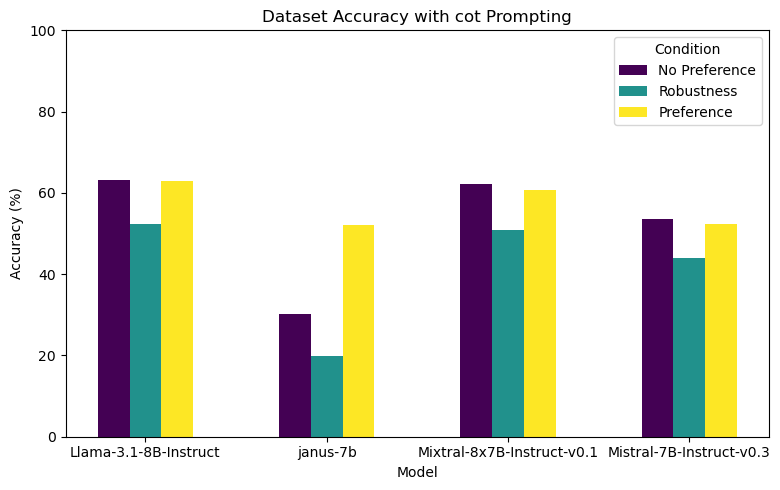

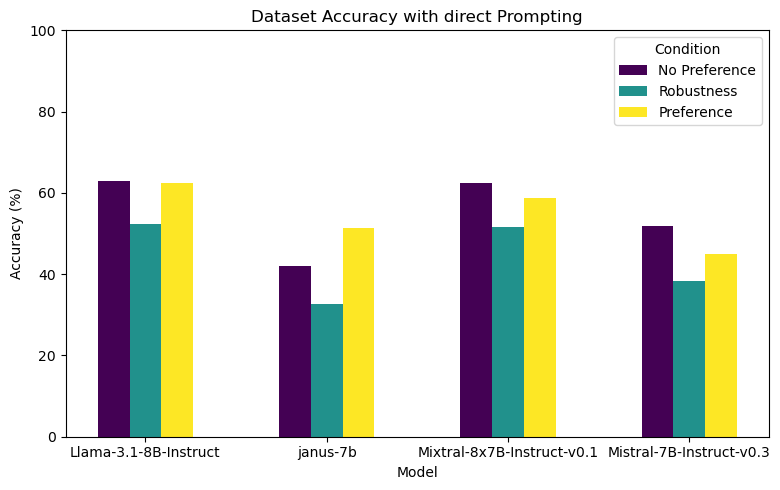

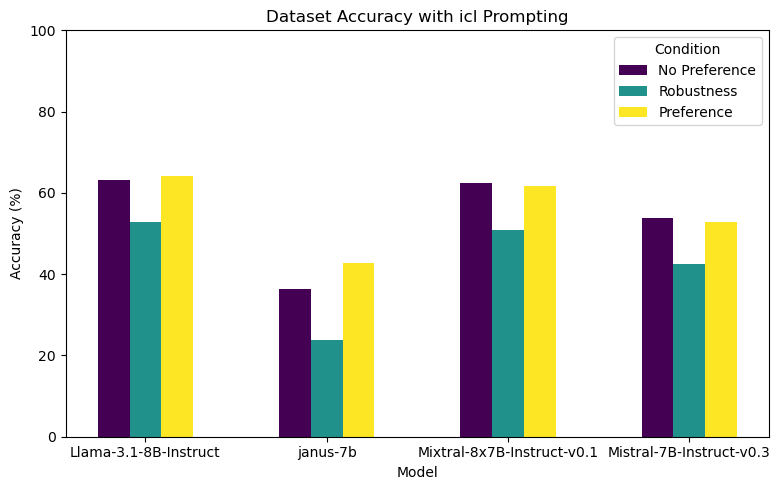

In [73]:
for i, method in enumerate(PROMPT_METHODS):
    measure_chunk = measures[i*4:(i+1)*4]

    values_nopref = [measure[2][0] for measure in measure_chunk]
    values_robust   = [measure[2][1] for measure in measure_chunk]
    values_pref   = [measure[2][2] for measure in measure_chunk]

    # Define bar width
    bar_width = 0.35

    # Generate positions for groups
    indices = np.arange(len(MODELS))

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))

    # Define a colormap and extract a color for each prompt method.
    cmap = plt.get_cmap('viridis', 3)
    colors = [cmap(i) for i in range(3)]

    # Plot the bars for each condition, offsetting the x positions for each set
    bars_nopref = ax.bar(indices - bar_width/2, values_nopref, width=bar_width/2,
                        label="No Preference", color=colors[0])
    # Plot the bars for each condition, offsetting the x positions for each set
    bars_robust = ax.bar(indices, values_robust, width=bar_width/2,
                        label="Robustness", color=colors[1])
    bars_pref   = ax.bar(indices + bar_width/2, values_pref, width=bar_width/2,
                        label="Preference", color=colors[2])

    # Add group labels on the x-axis
    ax.set_xticks(indices)
    ax.set_xticklabels(MODELS)
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)  # Fix y-axis range
    ax.set_title(f"Dataset Accuracy with {method} Prompting")
    ax.legend(title="Condition")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    figpath = os.path.join(stats_folder, f"{criterion}_{dataset_short}_accuracy.png")
    os.makedirs(os.path.dirname(figpath), exist_ok=True)
    plt.savefig(figpath, dpi=300)

    # # Display the plot
    # plt.show()
    plt.close()

## Heatmap of zero shot per dataset

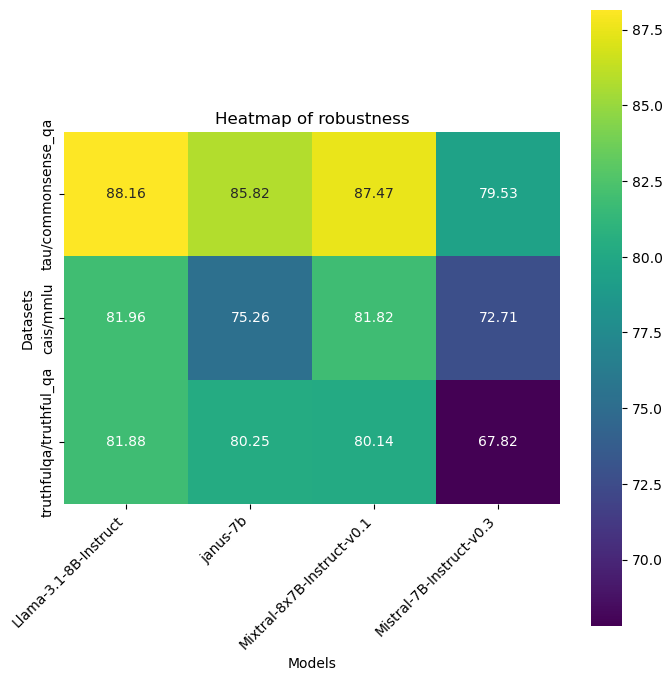

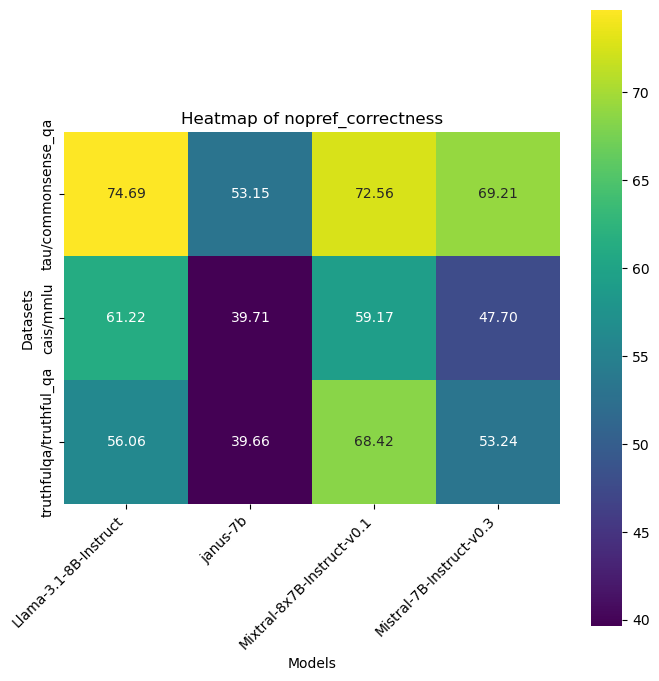

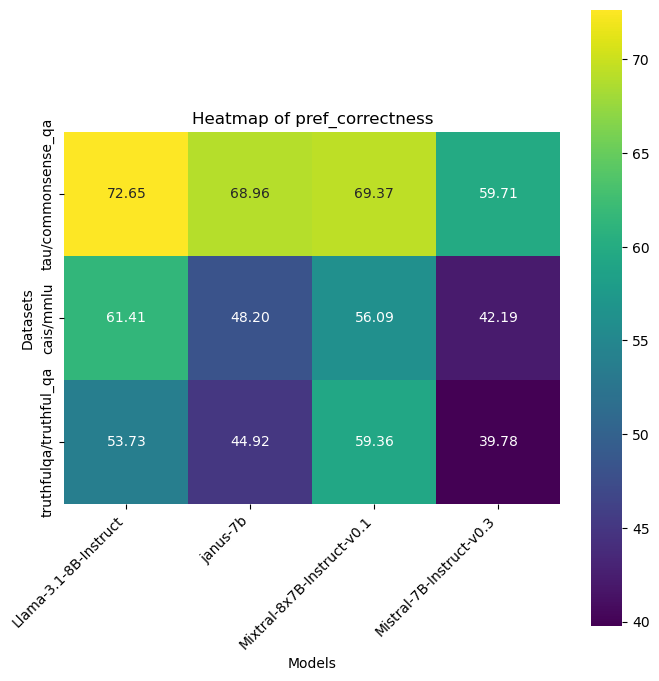

In [74]:
# Example definitions (replace with your actual lists)

# Dictionaries to store the difference (dataset performance - full dataset performance)
robustness_diff = {}
nopref_diff = {}
pref_diff = {}

# Loop over each model and compute differences
for model in MODELS:
    # Construct the file path for the full dataset
    full_dataset_path = os.path.join("results", "mcq_results", "relevant", "direct", "full", f"{model}-direct-full.csv")
    
    # If the file does not exist, assign NaNs for each dataset
    if not os.path.exists(full_dataset_path):
        print(f"Warning: Full dataset not found for {model}, skipping computation.")
        robustness_diff[model] = {ds: np.nan for ds in DATASETS_FULL}
        nopref_diff[model] = {ds: np.nan for ds in DATASETS_FULL}
        pref_diff[model] = {ds: np.nan for ds in DATASETS_FULL}
        continue

    full_df = pd.read_csv(full_dataset_path)

    # Compute overall full dataset metrics
    full_robustness = full_df.loc[full_df['nopref_correct'] == 1, 'pref_correct'].mean() * 100
    full_nopref = full_df['nopref_correct'].mean() * 100
    full_pref = full_df['pref_correct'].mean() * 100

    # Initialize inner dictionaries for the current model
    robustness_diff[model] = {}
    nopref_diff[model] = {}
    pref_diff[model] = {}

    # Compute metrics for each individual dataset and then their differences versus the full dataset
    for ds in DATASETS_FULL:
        dataset_df = full_df[full_df["source"] == ds]
        # Compute dataset metrics (multiplying by 100 to express percentages)
        ds_robustness = dataset_df.loc[dataset_df['nopref_correct'] == 1, 'pref_correct'].mean() * 100
        ds_nopref = dataset_df['nopref_correct'].mean() * 100
        ds_pref = dataset_df['pref_correct'].mean() * 100
        
        # Calculate differences (dataset - full)
        robustness_diff[model][ds] = ds_robustness
        nopref_diff[model][ds] = ds_nopref
        pref_diff[model][ds] = ds_pref

# Organize each metric difference into a DataFrame.
# Using .from_dict(..., orient='index') returns rows as models.
# We then take .T so rows become datasets and columns become models.
heatmap_data = {
    "robustness": pd.DataFrame.from_dict(robustness_diff, orient="index").T,
    "nopref_correctness": pd.DataFrame.from_dict(nopref_diff, orient="index").T,
    "pref_correctness": pd.DataFrame.from_dict(pref_diff, orient="index").T,
}

# Now, plot a heatmap for each metric
for metric, df in heatmap_data.items():
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis", cbar=True, square=True)
    # Ensure model names (columns) are rotated for clarity
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.title(f'Heatmap of {metric}')
    plt.ylabel("Datasets")
    plt.xlabel("Models")
    
    # Create directory if not existing and save the plot
    figpath = os.path.join(stats_folder, f"{metric}_heatmap.png")
    os.makedirs(os.path.dirname(figpath), exist_ok=True)
    plt.savefig(figpath, dpi=300)
    plt.show()
    plt.close()


## Bar Plot of Prompt Methods

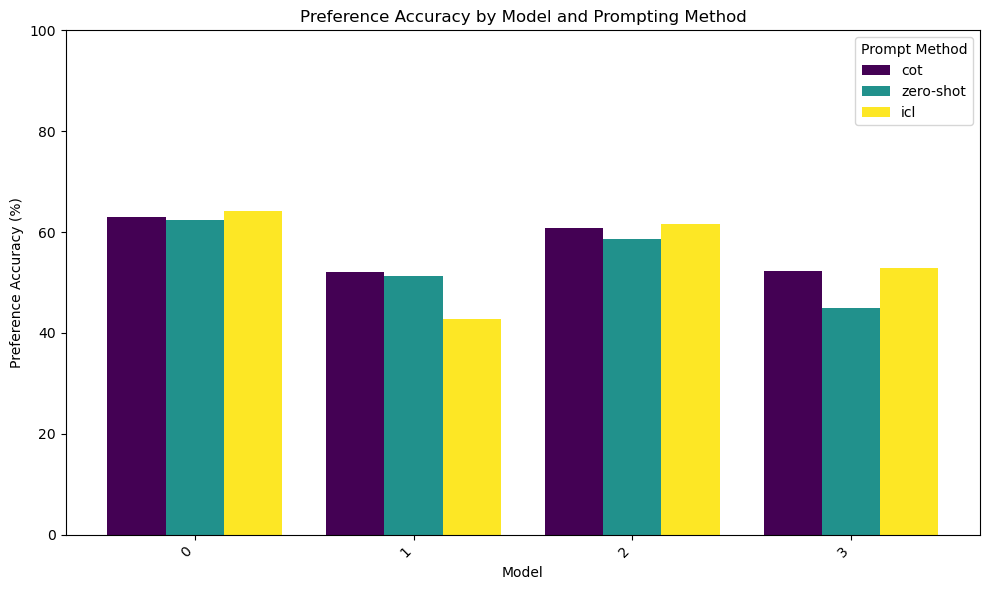

In [ ]:
# Initialize a nested dictionary to store the preference accuracy values.
# We use a list for each (model, prompt method) so that if there are multiple entries,
# we can average the results.
results = {model: {method: [] for method in PROMPT_METHODS} for model in MODELS}

# Process each valid combination.
for method, model, full_dataset_path in valid_combinations:
    if full_dataset_path is None:
        print(f"Skipping {method}, {model} as no full dataset found.")
        value = 0.0
    else:
        full_df = pd.read_csv(full_dataset_path)
        # Compute the preference correctness (mean of 'pref_correct' * 100).
        value = full_df['pref_correct'].mean() * 100
    results[model][method].append(value)

# In case there are multiple entries per (model, method) combination,
# average them. If there are no entries, we keep 0.0.
for model in results:
    for method in results[model]:
        if results[model][method]:
            results[model][method] = np.mean(results[model][method])
        else:
            results[model][method] = 0.0

# Prepare the data for plotting.
# The x-axis groups are by model.
indices = np.arange(len(MODELS))

# For each prompt method, collect a list of accuracy values in the same order as MODELS.
bar_data = {}
for method in PROMPT_METHODS:
    bar_data[method] = [results[model][method] for model in MODELS]

# Set up parameters for the grouped bar chart.
num_methods = len(PROMPT_METHODS)
total_width = 0.8  # Total width of all bars in a group.
bar_width = total_width / num_methods

# Create the bar plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define a colormap and extract a color for each prompt method.
cmap = plt.get_cmap('viridis', num_methods)
colors = [cmap(i) for i in range(num_methods)]

# Plot each prompt method’s bars, offsetting their positions within each group.
for i, method in enumerate(PROMPT_METHODS):
    if method == "direct":
        print_method = "zero-shot"
    else:
        print_method = method
    offset = (i - (num_methods - 1) / 2) * bar_width  # Center the bars in each group.
    ax.bar(indices + offset, bar_data[method], width=bar_width, label=print_method, color=colors[i])

# Label the x-axis with model names.
ax.set_xticks(indices)
# ax.set_xticklabels(MODELS)
ax.set_xticklabels(MODELS, rotation=45, ha="right")
ax.set_xlabel("Model")
ax.set_ylabel("Preference Accuracy (%)")
ax.set_ylim(0, 100)  # Fix y-axis range
ax.set_title("Preference Accuracy by Model and Prompting Method")
ax.legend(title="Prompt Method")

plt.tight_layout()

# Save the plot.
figpath = os.path.join(stats_folder, f"{criterion}_{dataset_short}_preference_accuracy.png")
os.makedirs(os.path.dirname(figpath), exist_ok=True)
plt.savefig(figpath, dpi=300)

# Display the plot.
plt.show()
plt.close()


## Make the line graph

/var/folders/td/cprp00894xq2p_fbrnfj89vr0000gn/T/ipykernel_58419/204394305.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


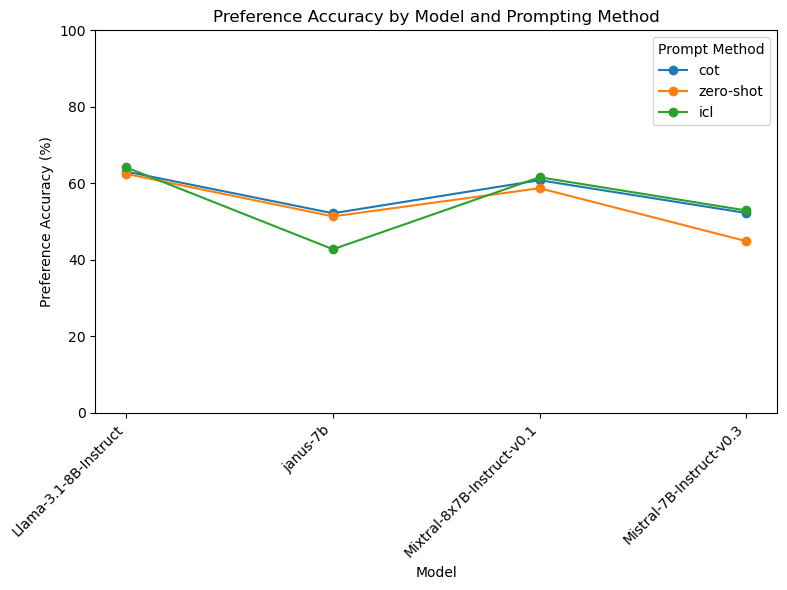

In [80]:
# Create a new figure for the line plot.
fig, ax = plt.subplots(figsize=(8, 6))

# For each prompt method, extract the accuracy values across models and plot them.
for method in PROMPT_METHODS:
    # Use a different label if the method is "direct"
    print_method = "zero-shot" if method == "direct" else method
    
    # Generate a list of accuracy values for this prompt method in the same order as MODELS.
    y_values = [results[model][method] for model in MODELS]
    
    # Create the line graph with markers.
    ax.plot(MODELS, y_values, marker='o', label=print_method)

# Label axes, set limits, title, and legend.
ax.set_xlabel("Model")
ax.set_ylabel("Preference Accuracy (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylim(0, 100)  # Fix the y-axis range
ax.set_title("Preference Accuracy by Model and Prompting Method")
ax.legend(title="Prompt Method")

plt.tight_layout()

# Save the plot to a file. Adjust the path and filename as required.
figpath = os.path.join(stats_folder, f"{criterion}_{dataset_short}_preference_accuracy_line.png")
os.makedirs(os.path.dirname(figpath), exist_ok=True)
plt.savefig(figpath, dpi=300)

# Display the plot.
plt.show()
plt.close()